In [9]:
import numpy as np
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram

# Deutsch-Jozsa Algorithm

In [10]:
def position_X_gates(circuit:QuantumCircuit, bit_string:str):
    # place the X gates
    for qubit in range(len(bit_string)):
        if bit_string[qubit] == '1':
            circuit.x(qubit)
    
def dj_oracle(qubits:int, balanced:bool = True):
    n = qubits
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    if balanced:
        # generate a random string that tells which CNOTs to activate
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        print(b_str)
        
        # position the first row of X gates
        position_X_gates(oracle_qc, b_str)
        
        # Do the controlled-NOT gates for each qubit, 
        # using the output qubit as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
            
        # position the last row of X gates
        position_X_gates(oracle_qc, b_str)
    else:
        # decide the oracle output (0 or 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Deutsch-Jozsa Oracle" # To show when we display the circuit
    return oracle_gate

In [11]:
def hadamard(circuit:QuantumCircuit, qubits):
    for qubit in range(qubits):
        circuit.h(qubit)

def dj_algorithm(oracle, qubits:int):
    n = qubits
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.barrier()
    dj_circuit.h(n)
    # set the input register in superposition:
    hadamard(dj_circuit, n)
    #introduce the oracle gate as a subroutine
    dj_circuit.append(oracle, range(n+1))
    # reverse superposition:
    hadamard(dj_circuit, n)
    
    #measure first register
    dj_circuit.measure(0,0)
    
    return dj_circuit 

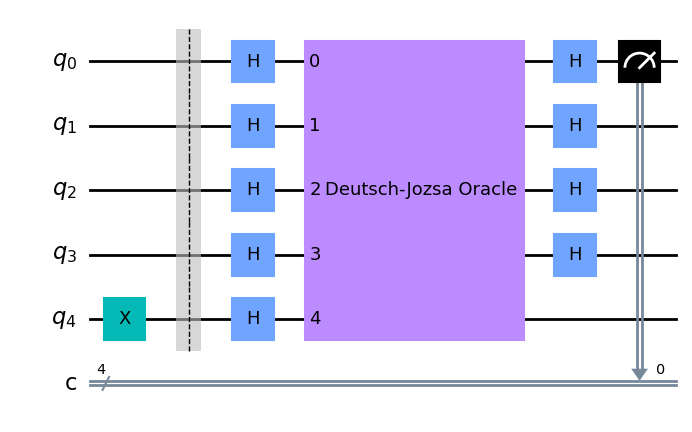

In [12]:
n = 4
const_oracle = dj_oracle(n, False)
dj_circuit = dj_algorithm(const_oracle, n)
dj_circuit.draw(output='mpl')

In [13]:
from qiskit.providers.aer import AerSimulator

def simulate(circuit, shots=1000):
    aer_sim = AerSimulator()
    transpiled_circuit = transpile(circuit, aer_sim)
    job = aer_sim.run(transpiled_circuit, shots=shots)  # run the experiment
    result = job.result()  # get the results
    # interpret the results as a "counts" dictionary
    return result.get_counts()

In [14]:
def interpret_result(result):
    bit = int(list(result.keys())[0])
    return 'Constant' if bit==0 else 'Balanced'

In [15]:
# use local simulator
result = simulate(dj_circuit)
interpret_result(result)

'Constant'

In [16]:
bal_oracle = dj_oracle(n, True)
dj_circuit = dj_algorithm(bal_oracle, n)
result = simulate(dj_circuit)
interpret_result(result)

1111


'Balanced'